# Predicting IPF labels with the HLCA

In this notebook, we will predict the cell type labels of an IPF dataset with the trained HLCA classifier. The trained classifier can be downloaded from [Zenodo](https://doi.org/10.5281/zenodo.6786357). There are two classifier here: one trained with the FAISS library and one without. The FAISS library makes the model faster but only works on Linux and with a gpu. More information about installation can be found [here](https://anaconda.org/pytorch/faiss-gpu)

If you want to train the classifier yourself, you can use the [HLCA - healthy notebook](https://github.com/lcmmichielsen/treeArches-reproducibility/blob/main/Figure2%20(HLCA-healthy)/HLCA%20-%20healthy%20(Figure%202%2C%20S3-5).ipynb).

The embeddings for the reference and IPF data we use, can be downloaded [here](https://zenodo.org/record/6337966#.YqrznidBx3h).

The count data for the reference [here](https://cellxgene.cziscience.com/collections/6f6d381a-7701-4781-935c-db10d30de293).

The count data for the IPF data [here](https://hmgubox.helmholtz-muenchen.de/f/8d3d2158f25b45278ba1/?dl=1).

In [1]:
import scanpy as sc
import scHPL
import numpy as np
import pickle
import matplotlib

In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
matplotlib.rcParams['pdf.fonttype'] = 42

### Read reference embedding & load classifier

In [3]:
LCA = sc.read('HLCA_emb_and_metadata.h5ad')

file_to_read = open("tree_HCLA_FAISS_withRE.pickle", "rb")
HLCA_tree = pickle.load(file_to_read)
file_to_read.close()

### Load query embedding & predict labels

In [4]:
IPF = sc.read('HLCA_extended_models_and_embs/surgery_output_embeddings/Sheppard_2020_emb_LCAv2.h5ad')

In [5]:
y_pred = scHPL.predict.predict_labels(IPF.X, 
               tree = HLCA_tree, 
               threshold = 0.5)

IPF.obs['scHPL_pred'] = y_pred


### Compare the predictions to original annotations

The count data and the original annotations for the IPF dataset can be downloaded here: http://tinyurl.com/hlca-explore

In [7]:
# Get original annotations
data = sc.read('HLCA_v1_extension_to_share.h5ad')
data_IPF = data[data.obs['study'] == 'Sheppard_2020']
data_IPF.obs['scHPL_pred'] = y_pred

/tmp/ipykernel_875861/948585720.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_IPF.obs['scHPL_pred'] = y_pred


In [15]:
order = ['Blood vessels', 'EC arterial', 'EC aerocyte capillary', 'EC general capillary', 
         'EC venous pulmonary', 'EC venous systemic', 'Lymphatic EC differentiating', 'Lymphatic EC mature',
         
         'Basal resting', 'Suprabasal', 
         'Multiciliated (nasal)', 'Multiciliated (non-nasal)',
         'Secretory', 'Transitional Club-AT2', 
         'Club (nasal)', 'Club (non-nasal)',
         'Goblet (bronchial)', 'Goblet (nasal)', 'Goblet (subsegmental)',    
         'AT1', 'AT2', 'AT2 proliferating', 
          
         'B cells', 'Plasma cells',
         'NK cells', 'CD4 T cells', 'CD8 T cells', 'T cells proliferating',
         
         'Myeloid', 'Dendritic cells', 'DC1', 'DC2', 
         'Migratory DCs', 'Plasmacytoid DCs',
         'Alveolar macrophages', 'Alveolar Mφ CCL3+', 'Alveolar Mφ MT-positive', 'Alveolar Mφ proliferating', 
         'Interstitial Mφ perivascular', 'Monocyte-derived Mφ', 
         'Classical monocytes', 'Non-classical monocytes',
         'Mast cells', 
         
         'Fibroblasts', 'Adventitial fibroblasts', 'Alveolar fibroblasts', 
         'Peribronchial fibroblasts',  'Pericytes', 'Subpleural fibroblasts', 
         'Myofibroblasts', 
         'Mesothelium', 'Fibromyocytes',        
         'SM activated stress response', 
           
         'Rejected (RE)', 'Rejection (dist)']


order2 = ['Endothelial', 'Epithelial', 'B cell', 'T cell', 'Dendritic cell',
           'Macrophage', 'Col1+']


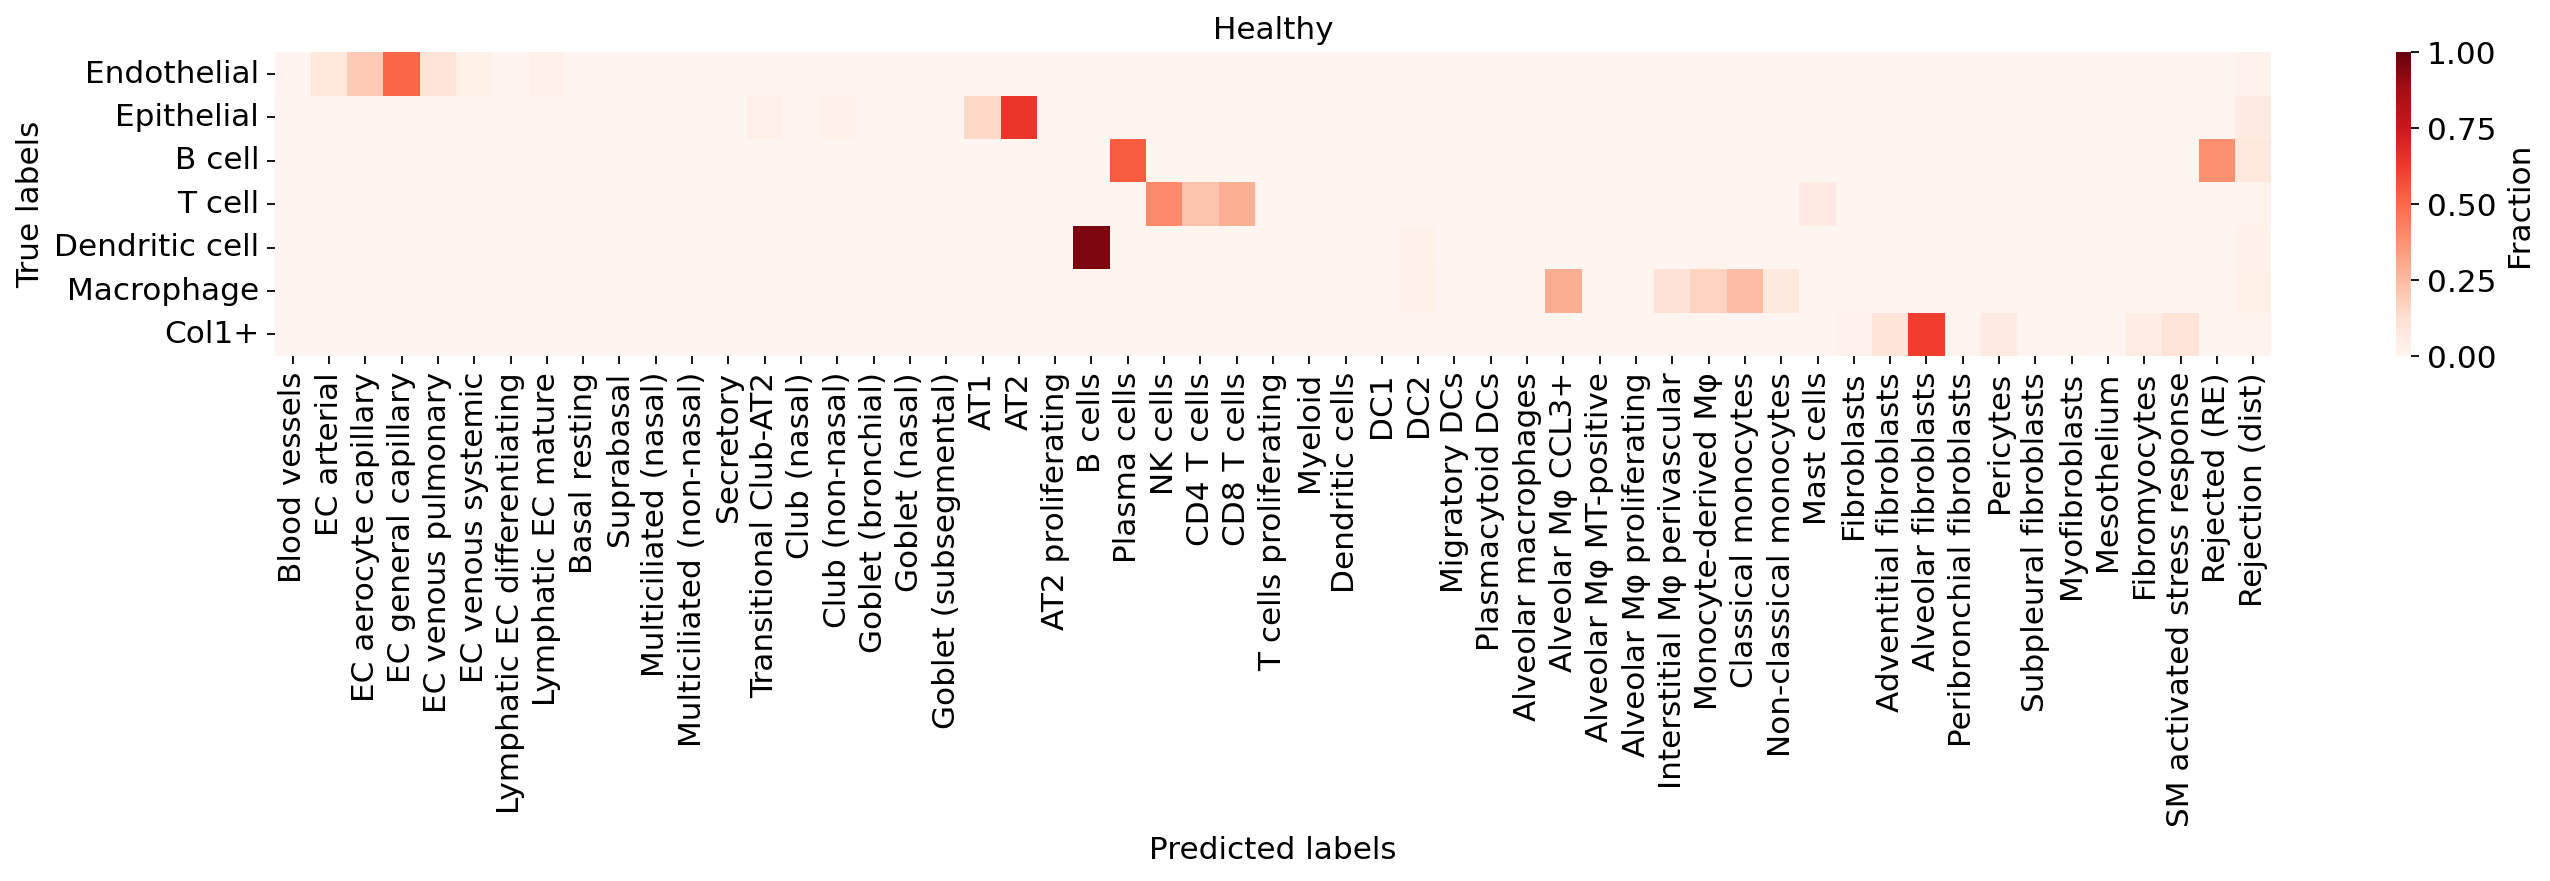

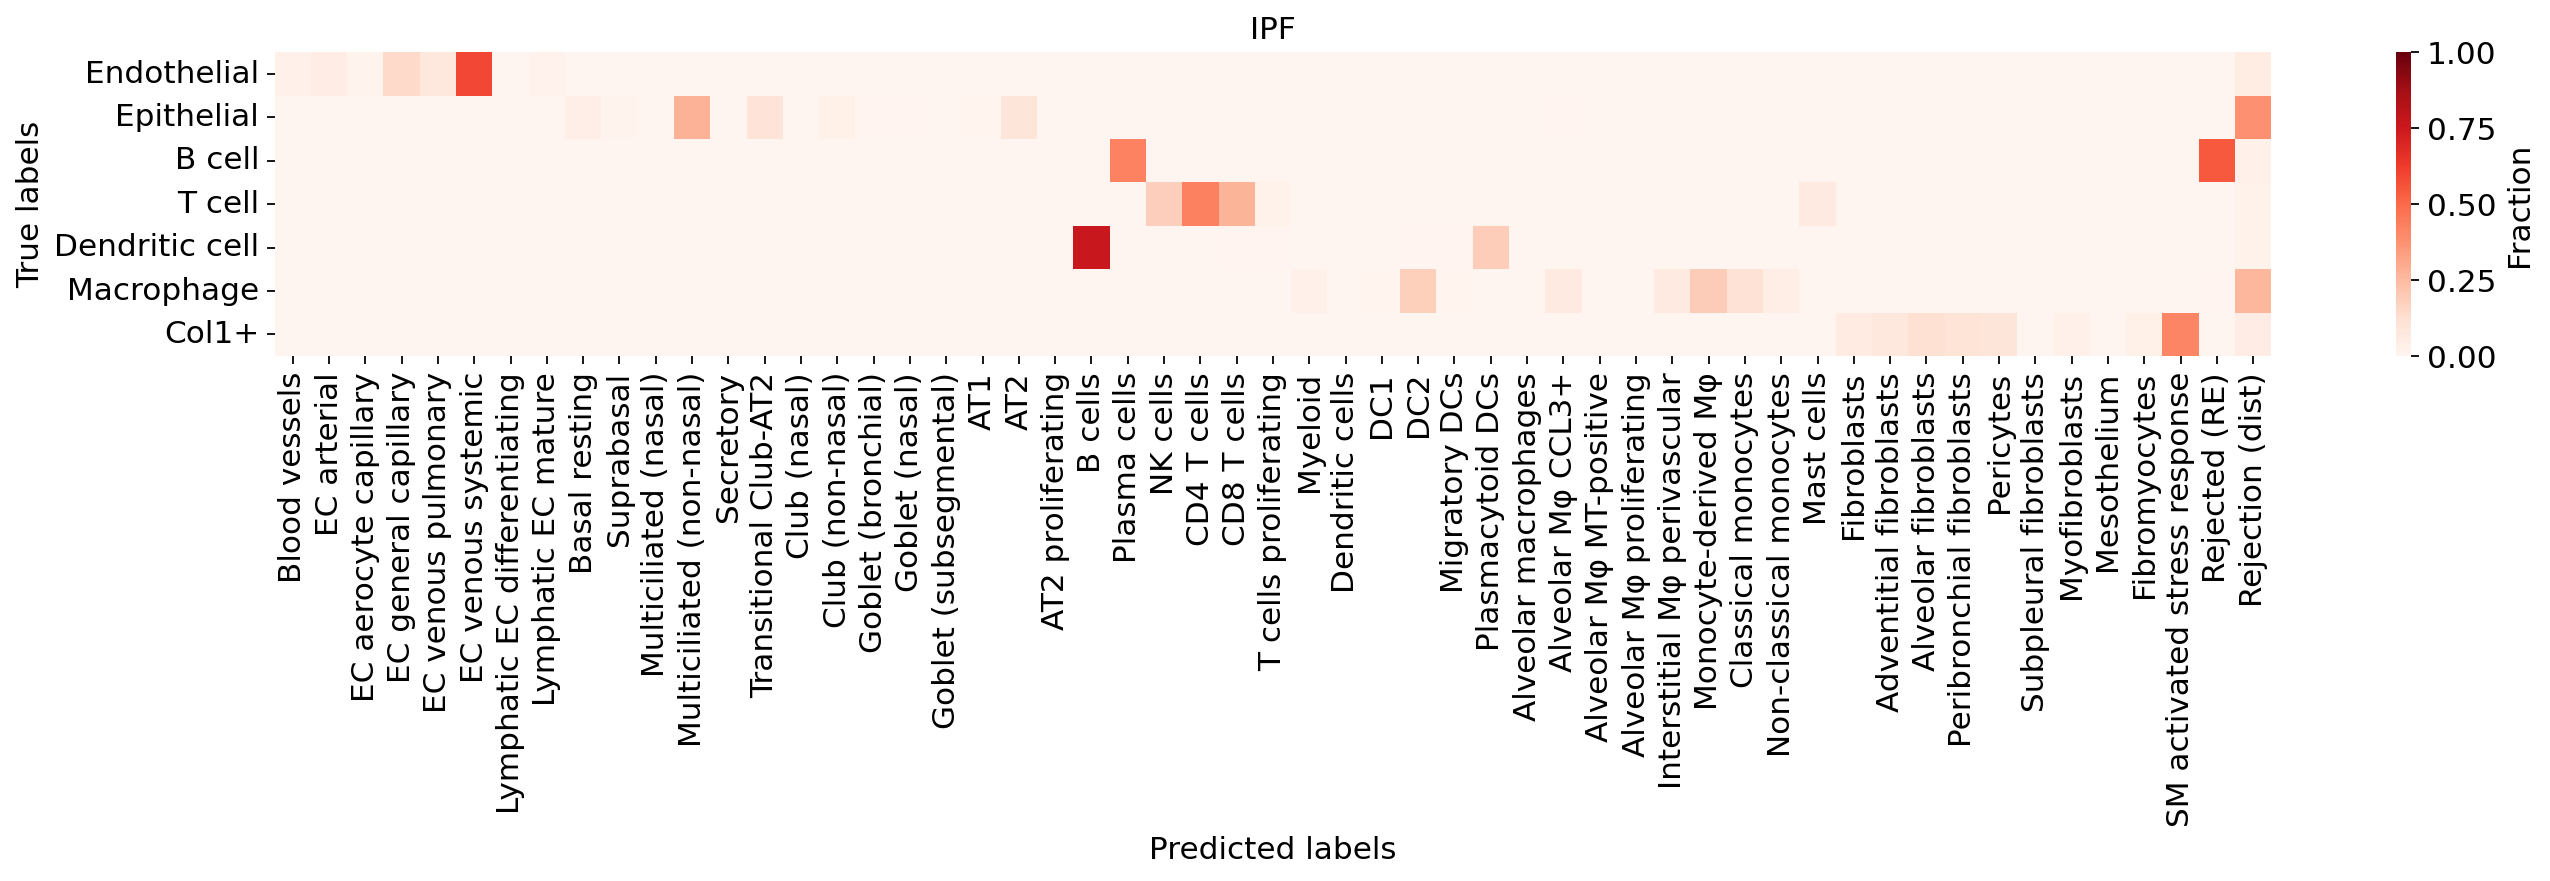

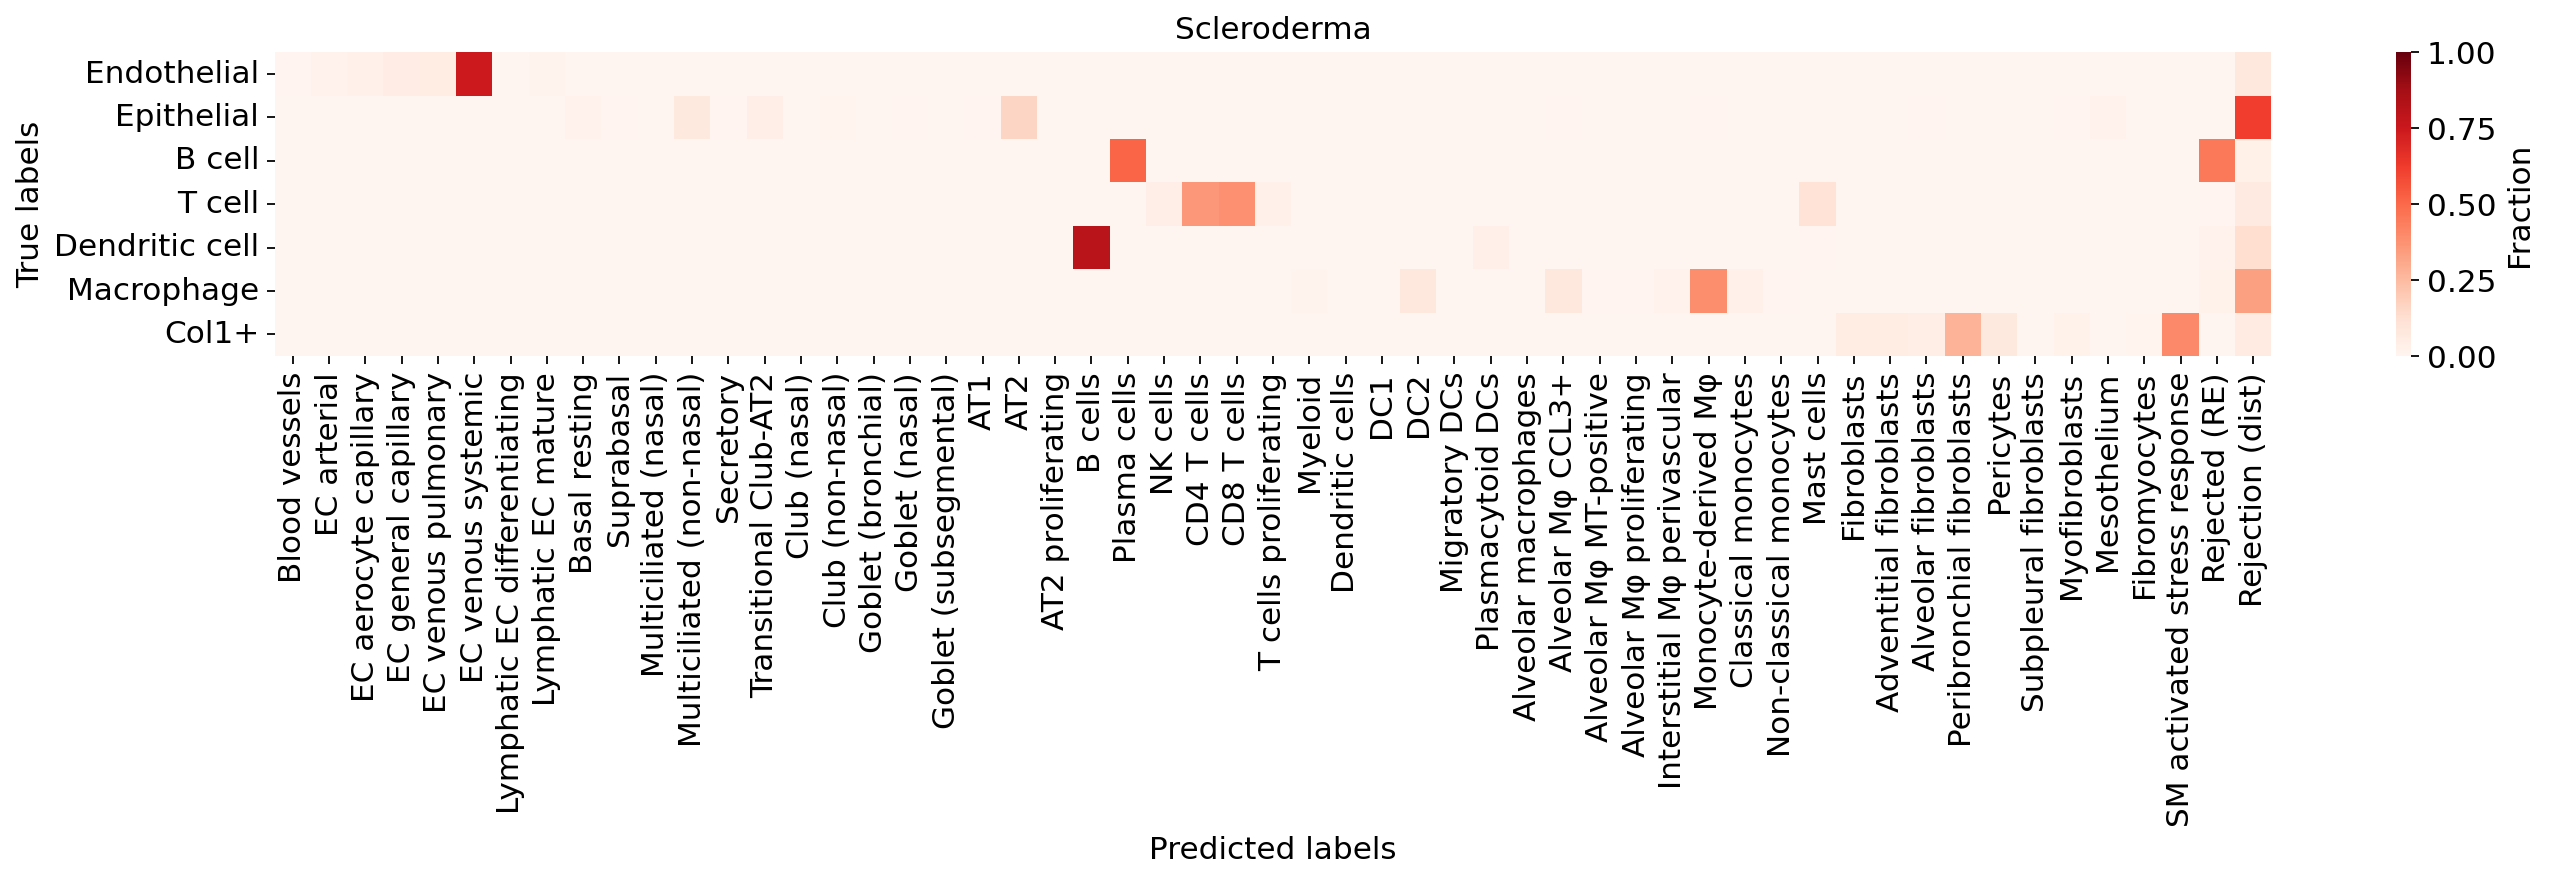

In [17]:
for c in np.unique(data_IPF.obs.condition):
    data_c = data_IPF[data_IPF.obs.condition == c]
    plt = scHPL.evaluate.heatmap(data_c.obs['scHPL_pred'], 
                                 data_c.obs['original_ann_nonharmonized'], 
                                 transpose=True, shape=(20,2.5), 
                                 title=c, 
                                 order_cols=order, 
                                 order_rows=order2
                                )


### Visualize the latent space

In [18]:
LCA.obs['batch'] = 'Reference'
IPF.obs['batch'] = data_IPF.obs.condition

In [20]:
## Remove the scleroderma from the data
tokeep = IPF.obs['batch'] != 'Scleroderma'
IPF = IPF[tokeep]
data_IPF = data_IPF[tokeep]

In [23]:
IPF.obs['ann_level_2'] = data_IPF.obs.original_ann_nonharmonized


/tmp/ipykernel_875861/2654255330.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  IPF.obs['ann_level_2'] = data_IPF.obs.original_ann_nonharmonized


In [26]:
LCA_IPF = sc.concat([LCA, IPF])
LCA_IPF

AnnData object with n_obs × n_vars = 646487 × 30
    obs: 'ann_level_2', 'batch'

In [27]:
sc.pp.neighbors(LCA_IPF)
sc.tl.leiden(LCA_IPF)
sc.tl.umap(LCA_IPF)

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


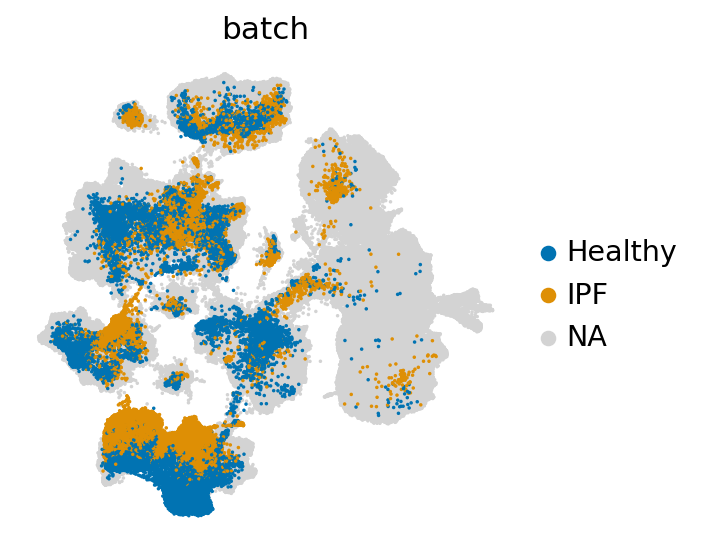

In [29]:
sc.pl.umap(LCA_IPF,
           color=['batch'], groups = ['Healthy', 'IPF'],
           frameon=False,
           wspace=0.6, s=10, palette=sns.color_palette('colorblind', as_cmap=True),
           save='_ref_IPF_noSL.pdf'
           )

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


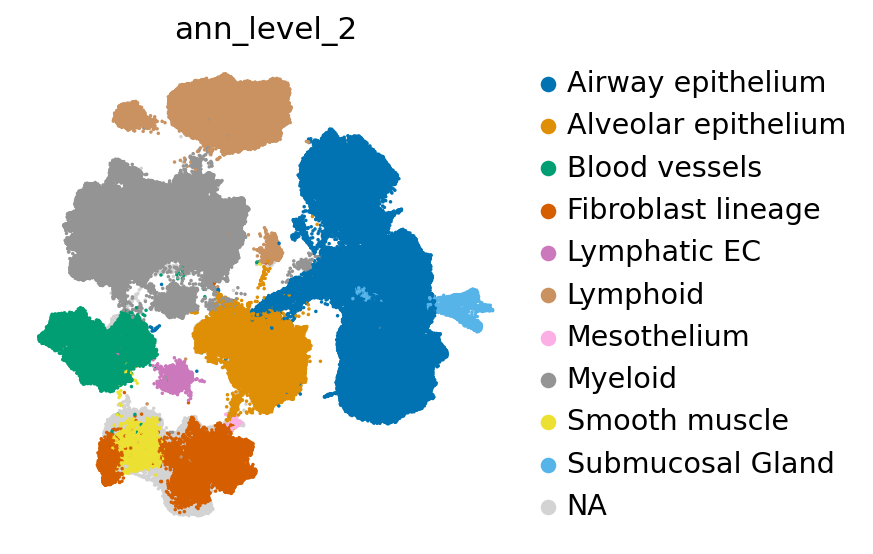

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


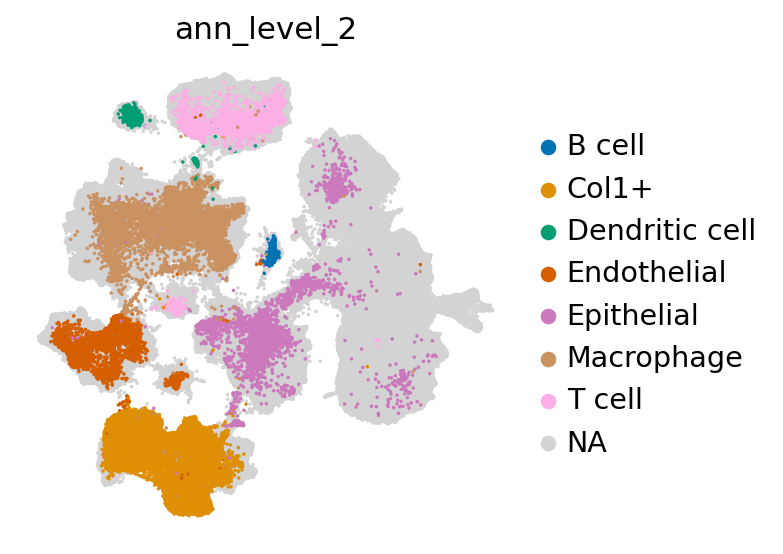

In [30]:
LCA_IPF.obs.ann_level_2 = LCA_IPF.obs.ann_level_2.cat.reorder_categories(['Airway epithelium', 'Alveolar epithelium', 
       'Blood vessels', 'Fibroblast lineage', 'Lymphatic EC', 'Lymphoid',
       'Mesothelium', 'Myeloid', 'Smooth muscle',
       'Submucosal Gland', 'B cell',
       'Col1+', 'Dendritic cell', 'Endothelial',
       'Epithelial', 'Macrophage', 'T cell'])

sc.pl.umap(LCA_IPF, color=['ann_level_2'], 
           groups = ['Airway epithelium', 'Alveolar epithelium', 
                     'Blood vessels', 'Fibroblast lineage', 'Lymphatic EC', 
                     'Lymphoid', 'Mesothelium', 'Myeloid', 'Smooth muscle',
                     'Submucosal Gland'],
           frameon=False,
           wspace=0.6, s=10, palette=sns.color_palette('colorblind', as_cmap=True),
           save='_ref_IPF_cp1.pdf'
           )

sc.pl.umap(LCA_IPF, color=['ann_level_2'], 
           groups = ['B cell', 'Col1+', 'Dendritic cell', 'Endothelial',
                     'Epithelial', 'Macrophage', 'T cell'],
           frameon=False,
           wspace=0.6, s=10, palette=sns.color_palette('colorblind', as_cmap=True),
           save='_ref_IPF_cp2.pdf'
           )


### Visualize expression of marker genes in the B-cells

In [31]:
sc.pp.normalize_total(data_IPF)
sc.pp.log1p(data_IPF)

/exports/humgen/lmichielsen/miniconda3_v2/envs/scarches2/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


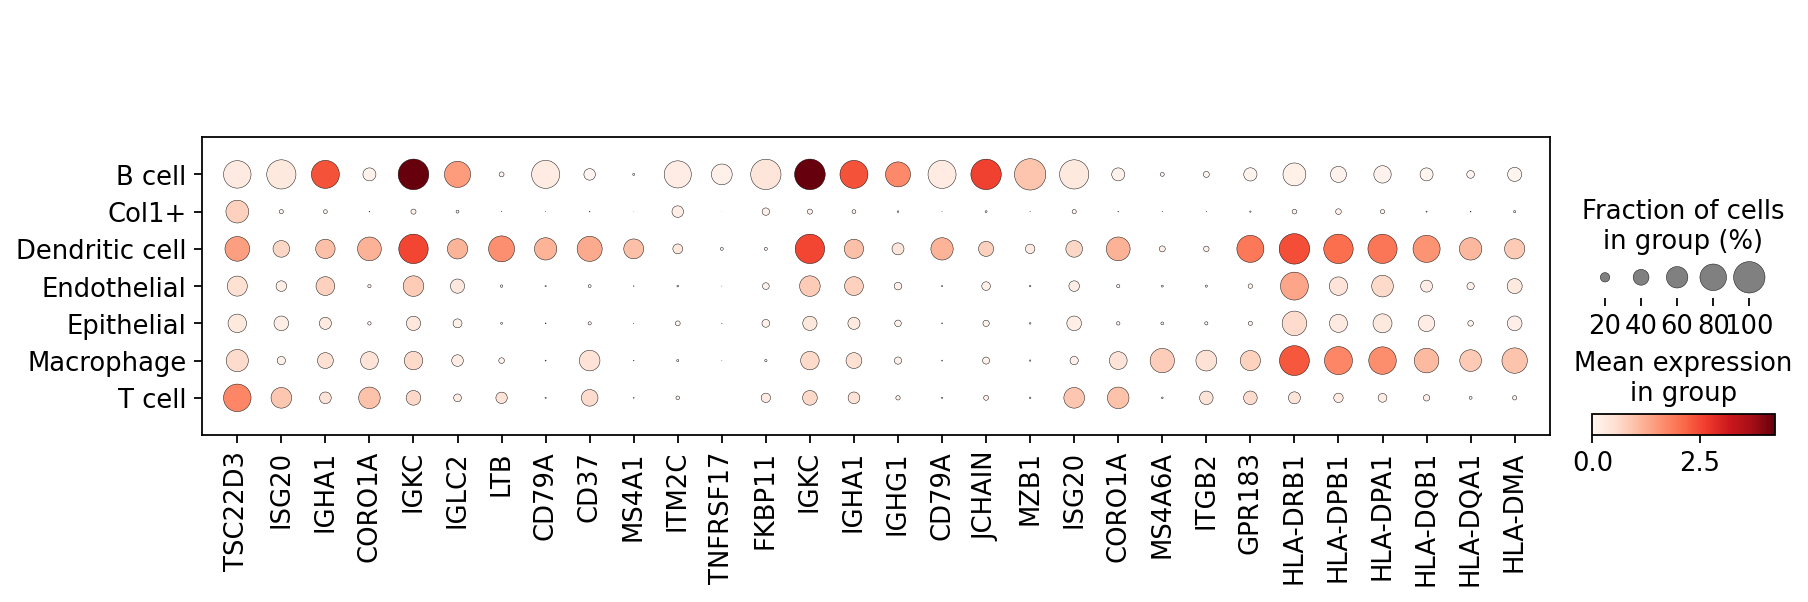

In [32]:
## B cell: 'TSC22D3', 'ISG20', 'IGHA1', 'CORO1A', 'IGKC', 'IGLC2', 'LTB', 'CD79A', 'CD37', 'MS4A1'
## Plasma: 'ITM2C', 'TNFRSF17', 'FKBP11', 'IGKC', 'IGHA1', 'IGHG1', 'CD79A', 'JCHAIN', 'MZB1', 'ISG20'
## Dendritic cells: 'CORO1A', 'MS4A6A', 'ITGB2', 'GPR183', 'HLA-DRB1', 'HLA-DPB1', 'HLA-DPA1', 'HLA-DQB1', 'HLA-DQA1', 'HLA-DMA'

sc.pl.dotplot(data_IPF, ['TSC22D3', 'ISG20', 'IGHA1', 'CORO1A', 'IGKC', 
                         'IGLC2', 'LTB', 'CD79A', 'CD37', 'MS4A1',
                         'ITM2C', 'TNFRSF17', 'FKBP11', 'IGKC',
                         'IGHA1', 'IGHG1', 'CD79A', 'JCHAIN', 'MZB1', 'ISG20',
                         'CORO1A', 'MS4A6A', 'ITGB2', 'GPR183', 
                         'HLA-DRB1', 'HLA-DPB1', 'HLA-DPA1', 'HLA-DQB1', 
                         'HLA-DQA1', 'HLA-DMA'], 
              groupby='original_ann_nonharmonized',
              save='_IPF_mkgenes.pdf')
